In [0]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
ls /content/gdrive/My\ Drive/cifar10

In [0]:
import tensorflow
print(tensorflow.__version__)

1.15.0


`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `1.15.0`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_41 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_42 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 15, 15, 32)        0         
_______________________________________________

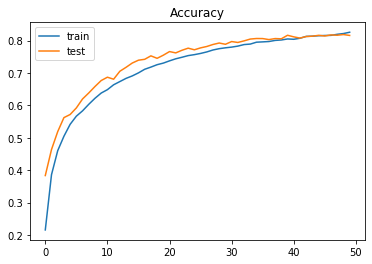

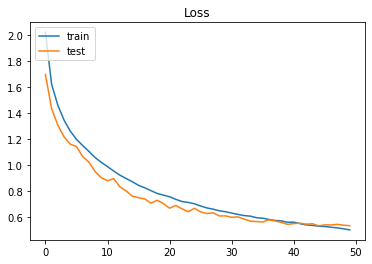

In [0]:
%tensorflow_version 1.15.0
import logging
import matplotlib.pyplot as plt
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import metrics, callbacks

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'


# setting
base_name = 'cifar_cnn'
epoch = 50
learning_rate = 0.0001
activation1 = 'relu'
activation2 = 'softmax'
optimizer = keras.optimizers.Adam(lr=learning_rate, decay=1e-6)
# optimizer = keras.optimizers.RMSprop(lr=learning_rate, decay=1e-6)
optimizer_name = 'Adam'
dropout = 0.40

logging.basicConfig(filename='/content/gdrive/My Drive/cifar10/{}_epoch{}_lr{}_func{}_opt{}_dropout{}.log'.format(
                                base_name, epoch, learning_rate, activation1, optimizer_name, dropout),
                    level=logging.DEBUG,
                    format='[%(asctime)s] %(name)s %(levelname)s \n%(message)s'
                    )
logger = logging.getLogger(__name__)

logger.info("-------------------- Learning Settings --------------------")
logger.info('epoch = {}'.format(epoch))
logger.info('learning_rate = {}'.format(learning_rate))
logger.info('activation_functions = {}, {}'.format(activation1, activation2))
logger.info('optimizer = {}'.format(optimizer_name))
logger.info('dropout = {}'.format(dropout))
logger.info("-------------------- Start training! --------------------")

# 데이터 변수 선언
num_classes = 10
im_rows = 32
im_cols = 32
in_shape = (im_rows, im_cols, 3)
im_size = im_rows * im_cols * 3

# (1) 데이터 읽어 들이기 -----------------------------------
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
logger.info('-------------------- cifar10.load_data() --------------------')

# (2) 데이터가공 ------------------------------------------
# 3차원 변환 및 정규화
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
logger.info('-------------------- Reshaping. --------------------')

# 레이블 데이터를 One-hot 형식으로 변환
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
logger.info('-------------------- One-hot Encoding. --------------------')


# CNN 모델 정의하기
model = Sequential()

# convolution layers - 특징 맵 추출
# polling layers - 특징 맵 축소 최대폴링/평균폴링
# fully connected layers - 각 레이어 결합. 2차원 특징맵을 1차원으로 전개
# activation function - 특징 강조
# output layer - 출력 레이어
model.add(Conv2D(32, (3, 3), padding='same', input_shape=in_shape))
model.add(Activation(activation1))
model.add(Conv2D(32, (3, 3)))
model.add(Activation(activation1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(dropout))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation(activation1))
model.add(Conv2D(64, (3, 3)))
model.add(Activation(activation1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(dropout))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation(activation1))
model.add(Conv2D(128, (3, 3)))
model.add(Activation(activation1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(dropout))

model.add(Flatten())    # 3차원 -> 1차원
model.add(Dense(512))   # Dense가 1차원밖에 못 받음
model.add(Activation(activation1))
model.add(Dropout(0.5))
model.add(Dense(512))
model.add(Activation(activation1))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation(activation2))
logger.info('-------------------- Define CNN model --------------------')
# model.summary()
logger.info(model.summary())

# 모델 생성
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy', metrics.categorical_accuracy]
)
logger.info('-------------------- model.compile() --------------------')

# 학습 실행하기
# 전체 데이터 반복 횟수 epochs => 50
# 전체 데이터 1회 반복 시 학습 데이터 크기 32
# validation_data => 각 epoch마다 검증 데이터 정확도 출력
# validation_split => 데이터셋 비율
logger.info("-------------------- Start model.fit() --------------------")

hist = model.fit(X_train, y_train,
                 batch_size=32,
                 epochs=epoch,
                 verbose=1,
                 validation_data=(X_test, y_test)
                 )

# 모델 평가하기
score = model.evaluate(X_test, y_test, verbose=1)
logger.info('Accuracy: {} / loss: {}'.format(score[1], score[0]))
print('정답률=', score[1], ' / loss=', score[0])

# 학습 상태를 그래프로 그리기
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
try:
    plt.savefig('/content/gdrive/My Drive/cifar10/{}_epoch{}_lr{}_func{}_opt{}_dropout{}_{}.{}'.format(
            base_name, epoch, learning_rate, activation1, optimizer_name, dropout, 'accuracy', 'png'))
    plt.savefig('/content/gdrive/My Drive/cifar10/{}_epoch{}_lr{}_func{}_opt{}_dropout{}_{}.{}'.format(
            base_name, epoch, learning_rate, activation1, optimizer_name, dropout, 'accuracy', 'svg'))
except Exception as e:
    logger.error(e)

try:
    plt.show()
except Exception as e:
    logger.error(e)

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss')
plt.legend(['train', 'test'], loc='upper left')
try:
    plt.savefig('/content/gdrive/My Drive/cifar10/{}_epoch{}_lr{}_func{}_opt{}_dropout{}_{}.{}'.format(
            base_name, epoch, learning_rate, activation1, optimizer_name, dropout, 'loss', 'png'))
    plt.savefig('/content/gdrive/My Drive/cifar10/{}_epoch{}_lr{}_func{}_opt{}_dropout{}_{}.{}'.format(
            base_name, epoch, learning_rate, activation1, optimizer_name, dropout, 'loss', 'svg'))
except Exception as e:
    logger.error(e)

try:
    plt.show()
except Exception as e:
    logger.error(e)

try:
    model.save_weights('/content/gdrive/My Drive/cifar10/{}_epoch{}_lr{}_func{}_opt{}_dropout{}.{}'.format(
            base_name, epoch, learning_rate, activation1, optimizer_name, dropout, 'h5'))
except Exception as e:
    logger.error(e)


`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `1.15.0`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


Using TensorFlow backend.














Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 30, 32)        128 

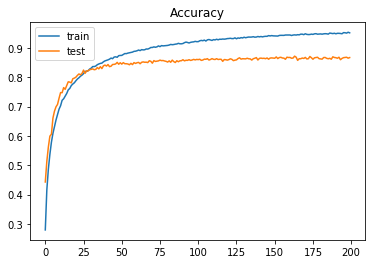

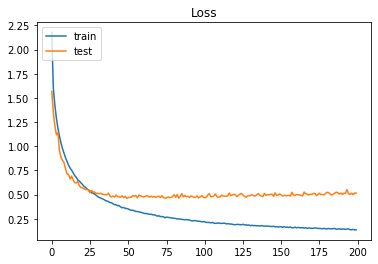

In [0]:
%tensorflow_version 1.15.0
import logging
import matplotlib.pyplot as plt
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import metrics, callbacks

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'


# setting
base_name = 'cifar_cnn'
epoch = 200
learning_rate = 0.0001
activation1 = 'relu'
activation2 = 'softmax'
optimizer = keras.optimizers.Adam(lr=learning_rate, decay=1e-6)
# optimizer = keras.optimizers.RMSprop(lr=learning_rate, decay=1e-6)
optimizer_name = 'Adam'
dropout = 0.40

logging.basicConfig(filename='/content/gdrive/My Drive/cifar10/{}_epoch{}_lr{}_func{}_opt{}_dropout{}.log'.format(
                                base_name, epoch, learning_rate, activation1, optimizer_name, dropout),
                    level=logging.DEBUG,
                    format='[%(asctime)s] %(name)s %(levelname)s \n%(message)s'
                    )
logger = logging.getLogger(__name__)

logger.info("-------------------- Learning Settings --------------------")
logger.info('epoch = {}'.format(epoch))
logger.info('learning_rate = {}'.format(learning_rate))
logger.info('activation_functions = {}, {}'.format(activation1, activation2))
logger.info('optimizer = {}'.format(optimizer_name))
logger.info('dropout = {}'.format(dropout))
logger.info("-------------------- Start training! --------------------")

# 데이터 변수 선언
num_classes = 10
im_rows = 32
im_cols = 32
in_shape = (im_rows, im_cols, 3)
im_size = im_rows * im_cols * 3

# (1) 데이터 읽어 들이기 -----------------------------------
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
logger.info('-------------------- cifar10.load_data() --------------------')

# (2) 데이터가공 ------------------------------------------
# 3차원 변환 및 정규화
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
logger.info('-------------------- Reshaping. --------------------')

# 레이블 데이터를 One-hot 형식으로 변환
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
logger.info('-------------------- One-hot Encoding. --------------------')


# CNN 모델 정의하기
model = Sequential()

# convolution layers - 특징 맵 추출
# polling layers - 특징 맵 축소 최대폴링/평균폴링
# fully connected layers - 각 레이어 결합. 2차원 특징맵을 1차원으로 전개
# activation function - 특징 강조
# output layer - 출력 레이어
model.add(Conv2D(32, (3, 3), padding='same', input_shape=in_shape))
model.add(Activation(activation1))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3)))
model.add(Activation(activation1))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation(activation1))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3)))
model.add(Activation(activation1))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation(activation1))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3)))
model.add(Activation(activation1))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())    # 3차원 -> 1차원
model.add(Dense(512))   # Dense가 1차원밖에 못 받음
model.add(Activation(activation1))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation(activation2))
logger.info('-------------------- Define CNN model --------------------')
# model.summary()
logger.info(model.summary())

# 모델 생성
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy', metrics.categorical_accuracy]
)
logger.info('-------------------- model.compile() --------------------')

# 학습 실행하기
# 전체 데이터 반복 횟수 epochs => 50
# 전체 데이터 1회 반복 시 학습 데이터 크기 32
# validation_data => 각 epoch마다 검증 데이터 정확도 출력
# validation_split => 데이터셋 비율
logger.info("-------------------- Start model.fit() --------------------")

hist = model.fit(X_train, y_train,
                 batch_size=32,
                 epochs=epoch,
                 verbose=1,
                 validation_data=(X_test, y_test)
                 )

# 모델 평가하기
score = model.evaluate(X_test, y_test, verbose=1)
logger.info('Accuracy: {} / loss: {}'.format(score[1], score[0]))
print('정답률=', score[1], ' / loss=', score[0])

# 학습 상태를 그래프로 그리기
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
try:
    plt.savefig('/content/gdrive/My Drive/cifar10/{}_epoch{}_lr{}_func{}_opt{}_dropout{}_{}.{}'.format(
            base_name, epoch, learning_rate, activation1, optimizer_name, dropout, 'accuracy', 'png'))
    plt.savefig('/content/gdrive/My Drive/cifar10/{}_epoch{}_lr{}_func{}_opt{}_dropout{}_{}.{}'.format(
            base_name, epoch, learning_rate, activation1, optimizer_name, dropout, 'accuracy', 'svg'))
except Exception as e:
    logger.error(e)

try:
    plt.show()
except Exception as e:
    logger.error(e)

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss')
plt.legend(['train', 'test'], loc='upper left')
try:
    plt.savefig('/content/gdrive/My Drive/cifar10/{}_epoch{}_lr{}_func{}_opt{}_dropout{}_{}.{}'.format(
            base_name, epoch, learning_rate, activation1, optimizer_name, dropout, 'loss', 'png'))
    plt.savefig('/content/gdrive/My Drive/cifar10/{}_epoch{}_lr{}_func{}_opt{}_dropout{}_{}.{}'.format(
            base_name, epoch, learning_rate, activation1, optimizer_name, dropout, 'loss', 'svg'))
except Exception as e:
    logger.error(e)

try:
    plt.show()
except Exception as e:
    logger.error(e)

try:
    model.save_weights('/content/gdrive/My Drive/cifar10/{}_epoch{}_lr{}_func{}_opt{}_dropout{}_acc{}.{}'.format(
            base_name, epoch, learning_rate, activation1, optimizer_name, dropout, score[1], 'h5'))
except Exception as e:
    logger.error(e)
